# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Matemática Para Data Science</font>

## <font color='blue'>Projeto 4</font>
### <font color='blue'>Matemática da Arquitetura Transformer na Análise e Forecast de Séries Temporais</font>

ATENÇÃO É TUDO QUE VOCÊ PRECISA!

https://arxiv.org/abs/1706.03762

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

Visite o PyPi e pesquise sobre cada um dos pacotes abaixo:
    
https://pypi.org/

Usaremos o HuggingFace como fonte de dados e do modelo pré-treinado.

https://huggingface.co/

In [2]:
!pip install -q transformers==4.37.2

In [3]:
!pip install -q datasets==2.16.1

In [4]:
!pip install -q evaluate==0.4.1

In [5]:
!pip install -q accelerate==0.26.1

In [6]:
!pip install -q -U gluonts==0.14.4

In [7]:
!pip install -q ujson==5.4.0

In [8]:
!pip install -q urllib3==1.26.16

In [9]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [10]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [11]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

https://ts.gluon.ai

In [12]:
# Imports
import evaluate
import torch
import transformers
import accelerate
import gluonts
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import lru_cache
from functools import partial
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from transformers import PretrainedConfig
from typing import Optional
from accelerate import Accelerator
from torch.optim import AdamW
from evaluate import load
from typing import Iterable
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches
from gluonts.time_feature import get_seasonality
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str
from gluonts.transform.sampler import InstanceSampler
from gluonts.time_feature import (time_features_from_frequency_str, TimeFeature, get_lags_for_frequency)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
import warnings
warnings.filterwarnings('ignore')

In [13]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando os Dados de Séries Temporais

https://huggingface.co/datasets/monash_tsf

In [14]:
# Carrega o dataset
dsa_dataset = load_dataset("monash_tsf", "tourism_monthly")

In [15]:
print(dsa_dataset)

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})


In [16]:
# Dados de treino
dsa_dataset['train']

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

## Explorando os Dados de Séries Temporais

In [17]:
# Vamos extrair os dados no índice zero
exemplo_treino = dsa_dataset['train'][0]

In [18]:
type(exemplo_treino)

dict

In [ ]:
exemplo_treino

In [20]:
# Como é um dicionário, vamos extrair a chave
exemplo_treino.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [21]:
print(exemplo_treino['start'])

1979-01-01 00:00:00


In [22]:
print(exemplo_treino['target'])

[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.420166015625, 2804.840087890

In [23]:
# Vamos extrair um elemento de validação
exemplo_valid = dsa_dataset['validation'][0]

In [24]:
exemplo_valid.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [25]:
print(exemplo_valid['start'])

1979-01-01 00:00:00


In [26]:
print(exemplo_valid['target'])

[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.420166015625, 2804.840087890

In [27]:
# Vamos extrair um elemento de teste
exemplo_test = dsa_dataset['test'][0]

In [28]:
print(exemplo_test['start'])

1979-01-01 00:00:00


In [29]:
print(exemplo_test['target'])

[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.420166015625, 2804.840087890

In [30]:
len(exemplo_treino['target'])

139

In [31]:
len(exemplo_valid['target'])

163

In [32]:
len(exemplo_test['target'])

187

## Visualizando a Série Temporal

In [33]:
# Frequência da série temporal (1 mês)
freq = "1M"

In [34]:
# Janela de previsão (24 meses)
prediction_length = 24

In [35]:
# Verifica se o comprimento dos dados de validação permite a janela de previsão
assert len(exemplo_treino["target"]) + prediction_length == len(exemplo_valid["target"])

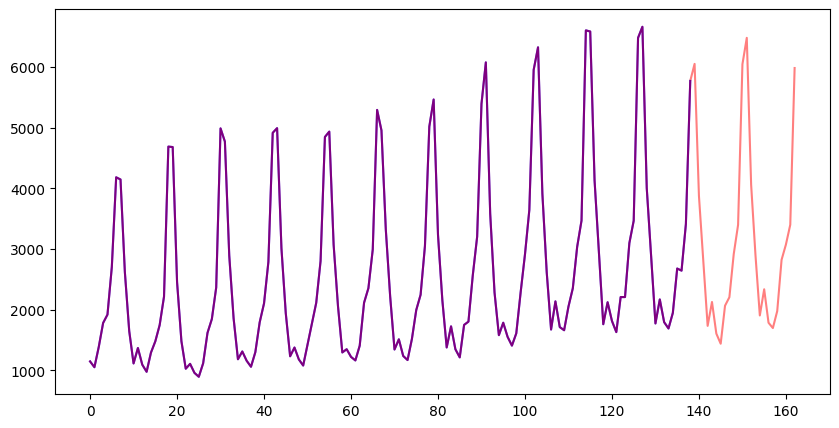

In [36]:
# Plot
figure, axes = plt.subplots(figsize = (10, 5))
axes.plot(exemplo_treino["target"], color = "blue")
axes.plot(exemplo_valid["target"], color = "red", alpha = 0.5)
plt.show()

## Convertendo o Formato de Data Para Períodos

In [37]:
# Datasets de treino e teste
dsa_dataset_treino = dsa_dataset["train"]
dsa_dataset_teste = dsa_dataset["test"]

A função abaixo é usada para converter objetos de data em períodos de datas usando pandas. Essa conversão é útil para trabalhar com séries temporais, pois os períodos podem representar melhor a granularidade dos dados (por exemplo, dia, mês, ano), dependendo da frequência (freq) fornecida. Esta função recebe uma data e a frequência desejada como argumentos, retornando um objeto pd.Period correspondente.

In [38]:
# Função para converter datas para períodos de datas (muda o formato da data)
def dsa_convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

A função abaixo é usada para ajustar o início de cada batch de dados. Ela aplica a função de conversão dsa_convert_to_pandas_period() a cada elemento na chave "start" do batch, transformando as datas de início em períodos pandas. Isso é feito para cada elemento do batch, garantindo que todos os pontos de dados tenham um marcador de início formatado corretamente de acordo com a frequência especificada. A função retorna o batch com os inícios ajustados.

In [39]:
# Função para definir o início do batch de dados
def dsa_define_start(batch, freq):
    batch["start"] = [dsa_convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

Finalmente, os datasets de treino e teste são ajustados para utilizar a função dsa_define_start() como uma transformação. Isso é feito usando o método set_transform() e aplicando a função partial() para fixar o argumento freq na função dsa_define_start(), garantindo que a frequência especificada seja usada na conversão de todas as datas de início nos datasets. Essa etapa prepara os datasets para que estejam no formato adequado para as etapas subsequentes de modelagem, com todos os pontos de dados tendo um marcador de período de início consistente de acordo com a granularidade temporal desejada.

Ou seja, preparamos os dados no formato de sequência, exatamete o que um modelo com arquitetura Transformer espera receber.

In [40]:
# Ajusta os datasets das séries temporais no formato apropriado
dsa_dataset_treino.set_transform(partial(dsa_define_start, freq = freq))
dsa_dataset_teste.set_transform(partial(dsa_define_start, freq = freq))

In [41]:
len(dsa_dataset_treino)

366

In [42]:
dsa_dataset_treino

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

In [43]:
dsa_dataset_treino['start']

[Period('1979-01', 'M'),
 Period('1979-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1985-01', 'M'),
 Period('1986-01', 'M'),
 Period('1986-01', 'M'),
 Period('1986-01', 'M'),
 Period('1986-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),
 Period('1980-01', 'M'),


## TimeSeries Transformer Config

Lembre-se de visitar sua amiga documentação periodicamente:

https://huggingface.co/docs/transformers/en/model_doc/time_series_transformer

In [44]:
# TimeSeries Transformer Config
dsa_config = TimeSeriesTransformerConfig(

    # Comprimento de previsão
    prediction_length = prediction_length,

    # Comprimento do contexto
    context_length = prediction_length * 2,

    # Lags sequence
    # "Lags" em séries temporais referem-se a pontos de dados anteriores em uma série de tempo.
    # Em outras palavras, um "lag" é um atraso temporal. Por exemplo, em uma série temporal mensal, o "lag"
    # de um mês refere-se aos dados do mês anterior.
    lags_sequence = get_lags_for_frequency(freq),

    # Adicionaremos 2 características de tempo ("mês do ano" e "idade da série"):
    num_time_features = len(time_features_from_frequency_str(freq)) + 1,

    # Temos um único recurso categórico estático, ou seja, o ID da série temporal
    num_static_categorical_features = 1,

    # Temos 366 valores possíveis
    cardinality = [len(dsa_dataset_treino)],

    # O modelo receberá uma embedding de tamanho 2 para cada um dos 366 valores possíveis:
    embedding_dimension = [2],

    # Parâmetros da rede neural do Transformer
    encoder_layers = 4,
    decoder_layers = 4,
    d_model = 32,
)

## TimeSeries Transformer For Prediction

Agora criamos o modelo (instância da classe).

In [45]:
# Cria o modelo com a config criada
modelo_dsa = TimeSeriesTransformerForPrediction(dsa_config)

Vamos compreender parte da Matemática por trás do Transformer, especificamente o módulo de atenção.

### Matemática do Modelo Transformer

https://arxiv.org/pdf/1706.03762.pdf

Vamos descrever as partes do modelo Transformer com algumas fórmulas. Os termos a seguir serão úteis para entender os cálculos.

- Q: vetor de consulta
- K: vetor de chave
- V: vetor de valor

As fórmulas para o mecanismo de atenção no Transformer são as seguintes:

1- Atenção Escalada por Produto Escalar

A função de atenção é usada para calcular a importância de diferentes partes da entrada. Ela recebe três entradas: Q, K e V. A saída é calculada como:

**Attention(Q, K, V) = softmax((QK^T) / sqrt(d_k))V**

onde d_k é a dimensão dos vetores-chave e o operador ^T indica a transposição de uma matriz. A operação de produto escalar entre Q e K ajuda a determinar a relevância entre cada par de consulta e chave. O resultado é então dividido pela raiz quadrada de d_k para evitar que os valores do produto escalar fiquem muito grandes. Por fim, a função softmax é aplicada para transformar os pesos em probabilidades que somam 1. Esses pesos são então usados para ponderar os vetores de valor.

2- Atenção Multi-cabeça

A atenção multi-cabeça permite que o modelo se concentre em diferentes partes da entrada para cada cabeça de atenção. Suponha que temos h cabeças de atenção. Para cada cabeça, primeiro transformamos Q, K e V com diferentes pesos aprendidos:

- Q_i = QW^Q_i
- K_i = KW^K_i
- V_i = VW^V_i

onde W^Q_i, W^K_i e W^V_i são os pesos aprendidos para a i-ésima cabeça.

Em seguida, aplicamos a atenção escalada por produto escalar para cada conjunto de Q_i, K_i e V_i:

**head_i = Attention(Q_i, K_i, V_i)**

A saída de todas as cabeças é então concatenada e linearmente transformada para produzir a saída final:

**MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O**

onde W^O é uma matriz de pesos aprendida.

3- Codificador e Decodificador

No codificador, cada camada consiste em atenção multi-cabeça seguida por uma rede neural feed-forward. A entrada passa pela atenção multi-cabeça e é então somada à entrada original (conexão residual) e normalizada. O resultado passa pela rede feed-forward, é somado à entrada e normalizado novamente.

No decodificador, temos uma camada adicional de atenção multi-cabeça que leva a saída do codificador como K e V. Isso permite que o decodificador leve em consideração a entrada inteira ao produzir cada token de saída.

## Pré-Processamento dos Dados

In [46]:
# Função para criar a transformação (sequência de dados)
def dsa_cria_transformacao(freq: str, config: PretrainedConfig) -> Transformation:

    remove_field_names = []

    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)

    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(

        # Passo 1: Remove campos estáticos/dinâmicos se não for especificado
        [RemoveFields(field_names = remove_field_names)]

        # Passo 2: Converte os dados para formato NumPy
        + (
            [
                AsNumpyArray(field = FieldName.FEAT_STATIC_CAT, expected_ndim = 1, dtype = int)
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(field = FieldName.FEAT_STATIC_REAL, expected_ndim = 1)
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(field = FieldName.TARGET, expected_ndim = 1 if config.input_size == 1 else 2,
            ),

            # Passo 3: Trata os NaN's preenchendo o alvo com zero e retornando a máscara
            AddObservedValuesIndicator(target_field = FieldName.TARGET, output_field = FieldName.OBSERVED_VALUES),

            # Passo 4: Adiciona recursos temporais com base na freq do mês do ano do conjunto de dados
            # no caso em que freq="M" eles servem como codificações posicionais
            AddTimeFeatures(
                start_field = FieldName.START,
                target_field = FieldName.TARGET,
                output_field = FieldName.FEAT_TIME,
                time_features = time_features_from_frequency_str(freq),
                pred_length = config.prediction_length,
            ),

            # Passo 5: Adiciona outro recurso temporal (apenas um único número)
            # Informa ao modelo onde está o valor da série temporal, uma espécie de contador em execução
            AddAgeFeature(
                target_field = FieldName.TARGET,
                output_field = FieldName.FEAT_AGE,
                pred_length = config.prediction_length,
                log_scale = True,
            ),

            # Passo 6: Empilha verticalmente todos os recursos temporais na chave FEAT_TIME
            VstackFeatures(
                output_field = FieldName.FEAT_TIME,
                input_fields = [FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),

            # Passo 7: Renomeia para corresponder aos nomes no dataset extraído do HuggingFace
            RenameFields(
                mapping = {
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Divisão nas Amostras de Treino, Validação e Teste

In [47]:
# Define uma função para criar um divisor de instâncias e separar os dados em conjuntos de treino, validação e teste
def dsa_create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:

    # Garante que o modo especificado seja um dos modos aceitos: treino, validação ou teste
    assert mode in ["train", "validation", "test"]

    # Define um dicionário mapeando cada modo para um sampler específico ou utiliza samplers padrões baseados na configuração
    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(

            # Sampler para treino, esperando um número específico de instâncias com um mínimo de pontos futuros
            num_instances = 1.0, min_future = config.prediction_length
        ),
        "validation": validation_sampler

        # Sampler para validação, dividindo com base em um mínimo de pontos futuros
        or ValidationSplitSampler(min_future = config.prediction_length),

        # Sampler para teste, sem necessidade de pontos futuros específicos
        "test": TestSplitSampler(),
    }[mode]

    # Cria e retorna um divisor de instâncias configurado com o sampler adequado e outras definições relevantes
    return InstanceSplitter(

        # Campo alvo para a previsão
        target_field = "values",

        # Campo que indica se um ponto de dados é um preenchimento (padding)
        is_pad_field = FieldName.IS_PAD,

        # Campo que indica o início da série temporal
        start_field = FieldName.START,

        # Campo que indica o início da previsão
        forecast_start_field = FieldName.FORECAST_START,

        # O sampler de instâncias escolhido baseado no modo
        instance_sampler = instance_sampler,

        # Define o comprimento do contexto passado
        past_length = config.context_length + max(config.lags_sequence),

        # Define o comprimento da previsão futura
        future_length = config.prediction_length,

        # Campos adicionais da série temporal a serem incluídos
        time_series_fields = ["time_features", "observed_mask"],
    )

## Criação dos Dataloaders

In [48]:
# Define uma função para criar um DataLoader de treinamento com base nas configurações e dados fornecidos
def dsa_cria_dataloader_treino(config: PretrainedConfig,
                               freq,
                               data,
                               batch_size: int,
                               num_batches_per_epoch: int,
                               shuffle_buffer_length: Optional[int] = None,
                               cache_data: bool = True,
                               **kwargs) -> Iterable:

    # Inicia a lista de nomes de entradas para previsão baseando-se na configuração de características estáticas e temporais
    PREDICTION_INPUT_NAMES = ["past_time_features", "past_values", "past_observed_mask", "future_time_features"]

    # Adiciona o nome da característica categórica estática à lista se presente na configuração
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    # Adiciona o nome da característica real estática à lista se presente na configuração
    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    # Estende a lista de nomes de entradas para incluir os dados de treinamento específicos
    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    # Cria a transformação dos dados com base na frequência e configuração fornecida
    transformation = dsa_cria_transformacao(freq, config)

    # Aplica a transformação nos dados no modo de treinamento
    transformed_data = transformation.apply(data, is_train = True)

    # Se solicitado, armazena em cache os dados transformados para otimizar o treinamento
    if cache_data:
        transformed_data = Cached(transformed_data)

    # Cria um divisor de instâncias para o treinamento que define como as janelas de dados serão amostradas
    instance_splitter = dsa_create_instance_splitter(config, "train")

    # Cria um fluxo cíclico dos dados transformados para amostragem contínua
    stream = Cyclic(transformed_data).stream()

    # Aplica o divisor de instâncias ao fluxo de dados para gerar instâncias de treinamento
    training_instances = instance_splitter.apply(stream, is_train = True)

    # Retorna os lotes empilhados das instâncias de treinamento conforme especificado
    return as_stacked_batches(
        training_instances,
        batch_size = batch_size,
        shuffle_buffer_length = shuffle_buffer_length,  # Define o comprimento do buffer de embaralhamento, se aplicável
        field_names = TRAINING_INPUT_NAMES,  # Especifica os nomes dos campos a serem incluídos nos lotes
        output_type = torch.tensor,  # Define o tipo de saída dos lotes
        num_batches_per_epoch = num_batches_per_epoch,  # Especifica o número de lotes por época
    )

In [49]:
# Define uma função para criar um DataLoader de teste a partir de configurações pré-definidas e dados
def dsa_cria_dataloader_teste(config: PretrainedConfig, freq, data, batch_size: int, **kwargs):

    # Define os nomes das entradas necessárias para previsão baseadas na configuração
    PREDICTION_INPUT_NAMES = ["past_time_features", "past_values", "past_observed_mask", "future_time_features"]

    # Se houver características categóricas estáticas, adiciona ao conjunto de entradas de previsão
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    # Se houver características reais estáticas, adiciona ao conjunto de entradas de previsão
    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    # Cria a transformação a ser aplicada nos dados com base na frequência e configuração
    transformation = dsa_cria_transformacao(freq, config)

    # Aplica a transformação aos dados no modo de teste (não treinamento)
    transformed_data = transformation.apply(data, is_train=False)

    # Cria um amostrador de instâncias para o modo de teste que irá selecionar a última janela de contexto vista durante o treinamento
    instance_sampler = dsa_create_instance_splitter(config, "test")

    # Aplica o amostrador de instâncias aos dados transformados no modo de teste
    testing_instances = instance_sampler.apply(transformed_data, is_train = False)

    # Retorna os lotes empilhados como tensores PyTorch, com um tamanho de lote especificado e usando os nomes de campos definidos
    return as_stacked_batches(
        testing_instances,
        batch_size = batch_size,
        output_type = torch.tensor,
        field_names = PREDICTION_INPUT_NAMES,
    )

In [50]:
# Cria o dataloader de treino
dl_treino = dsa_cria_dataloader_treino(config = dsa_config,
                                       freq = freq,
                                       data = dsa_dataset_treino,
                                       batch_size = 256,
                                       num_batches_per_epoch = 100)

In [51]:
# Imprime as chaves de um batch de dados
batch = next(iter(dl_treino))
for k, v in batch.items():
    print(k)

past_time_features
past_values
past_observed_mask
future_time_features
static_categorical_features
future_values
future_observed_mask


In [52]:
# Imprime as chaves e respectivos valores de um batch de dados
batch = next(iter(dl_treino))
for k, v in batch.items():
    print(k, v)

past_time_features tensor([[[ 0.3182,  1.3617],
         [ 0.4091,  1.3802],
         [ 0.5000,  1.3979],
         ...,
         [ 0.1364,  2.0212],
         [ 0.2273,  2.0253],
         [ 0.3182,  2.0294]],

        [[ 0.5000,  2.1959],
         [-0.5000,  2.1987],
         [-0.4091,  2.2014],
         ...,
         [ 0.3182,  2.3784],
         [ 0.4091,  2.3802],
         [ 0.5000,  2.3820]],

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.4091,  1.7993],
         [-0.3182,  1.8062],
         [-0.2273,  1.8129]],

        ...,

        [[-0.4091,  2.1673],
         [-0.3182,  2.1703],
         [-0.2273,  2.1732],
         ...,
         [ 0.5000,  2.3598],
         [-0.5000,  2.3617],
         [-0.4091,  2.3636]],

        [[ 0.0455,  1.7482],
         [ 0.1364,  1.7559],
         [ 0.2273,  1.7634],
         ...,
         [-0.1364,  2.1399],
         [-0.0455,  2.1430],
         [ 0.0455,  2.1461]],

        [[ 0.1364

In [53]:
# Cria o dataloader de teste
dl_teste = dsa_cria_dataloader_teste(config = dsa_config,
                                     freq = freq,
                                     data = dsa_dataset_teste,
                                     batch_size = 64)

## Loop de Treinamento do Modelo

In [54]:
# Cria o acelerador
accelerator = Accelerator()

In [55]:
# Registra o device
device = accelerator.device

In [56]:
device

device(type='cuda')

In [57]:
# Envia o modelo para o device
modelo_dsa.to(device)

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(366, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=22, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(72, 32)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, element

In [58]:
# Otimizador
optimizer = AdamW(modelo_dsa.parameters(), lr = 6e-4, betas = (0.9, 0.95), weight_decay = 1e-1)

In [59]:
# Carrega o modelo, o otimizador e o dataloader de treino
modelo_dsa, optimizer, dl_treino = accelerator.prepare(modelo_dsa, optimizer, dl_treino)

### Matemática da Otimização do Modelo

Aqui estão as etapas do AdamW em termos matemáticos:

**Cálculo dos Momentos de Primeira e Segunda Ordem**

Para cada parâmetro θ, Adam mantém uma estimativa do primeiro momento (a média móvel dos gradientes passados) e do segundo momento (a média móvel dos quadrados dos gradientes passados). Para uma dada etapa t, gradiente g_t e parâmetros de decaimento β1 e β2, essas estimativas são atualizadas da seguinte forma:

- m_t = β1 * m_(t-1) + (1 - β1) * g_t
- v_t = β2 * v_(t-1) + (1 - β2) * g_t^2

**Correção de Viés**

Como m_t e v_t são inicializados como zero, eles são tendenciosos para zero no início do treinamento. Portanto, Adam realiza uma correção de viés para compensar isso:

- m_t_hat = m_t / (1 - β1^t)
- v_t_hat = v_t / (1 - β2^t)

**Atualização de Peso**

Finalmente, os pesos são atualizados com uma taxa de aprendizado η e um termo de decaimento de peso w:

**θ = θ - η * (m_t_hat / (sqrt(v_t_hat) + ε) + w * θ)**

Onde ε é um termo de suavização para evitar a divisão por zero (geralmente algo como 1e-8).

AdamW difere do Adam na forma como o termo de decaimento de peso é aplicado. No Adam original, o decaimento de peso é aplicado antes do cálculo do gradiente, o que pode levar a um acoplamento entre a atualização do peso e a escala do gradiente. AdamW aplica o decaimento de peso diretamente na etapa de atualização do peso, o que "desacopla" a regularização do decaimento de peso da escala do gradiente.

O cálculo das derivadas é uma parte fundamental do treinamento de redes neurais e é aplicado durante o processo de retropropagação (backpropagation), que é usado para atualizar os pesos da rede. No contexto do otimizador AdamW (ou qualquer otimizador baseado em gradiente), a derivada é usada para calcular o gradiente da função de perda com relação a cada peso na rede.

Na prática, você não precisa calcular essas derivadas manualmente. Frameworks modernos de aprendizado profundo, como TensorFlow e PyTorch, usam diferenciação automática para calcular as derivadas. Você simplesmente define a função de perda e o framework cuida de calcular os gradientes para você.

No caso específico do AdamW, a derivada é usada para calcular o gradiente g_t na etapa de atualização de momentos. Esse gradiente é simplesmente a derivada da função de perda com relação ao peso específico que está sendo atualizado. O gradiente indica a direção e a magnitude da mudança no peso que resultará no maior decréscimo na função de perda.

Então, em resumo, a derivada é usada no cálculo do gradiente, que é então usado para atualizar os pesos da rede neural na direção que minimiza a função de perda. Queremos os pesos que levem ao menor erro possível.

In [60]:
%%time

modelo_dsa.train()

# Inicia o loop de treinamento para um número pré-definido de épocas
for epoch in range(10):

    # Itera sobre os lotes do DataLoader de treinamento
    for idx, batch in enumerate(dl_treino):

        # Zera os gradientes do otimizador para evitar acumulação de gradientes de iterações anteriores
        optimizer.zero_grad()

        # Gera as saídas do modelo passando as características adequadas do lote atual
        outputs = modelo_dsa(

            # Passa características categóricas estáticas para o dispositivo se configurado
            static_categorical_features = batch["static_categorical_features"].to(device)
            if dsa_config.num_static_categorical_features > 0
            else None,

            # Passa características reais estáticas para o dispositivo se configurado
            static_real_features = batch["static_real_features"].to(device)
            if dsa_config.num_static_real_features > 0
            else None,

            # Passa características temporais passadas para o dispositivo
            past_time_features = batch["past_time_features"].to(device),

            # Passa valores passados para o dispositivo
            past_values = batch["past_values"].to(device),

            # Passa características temporais futuras para o dispositivo
            future_time_features = batch["future_time_features"].to(device),

            # Passa valores futuros para o dispositivo (usado para treinamento supervisionado)
            future_values = batch["future_values"].to(device),

            # Passa a máscara de observações passadas para o dispositivo
            past_observed_mask = batch["past_observed_mask"].to(device),

            # Passa a máscara de observações futuras para o dispositivo
            future_observed_mask = batch["future_observed_mask"].to(device),
        )

        # Atribui a perda calculada pelas saídas do modelo
        loss = outputs.loss

        # Realiza a retropropagação do erro para ajustar os pesos do modelo
        accelerator.backward(loss)

        # Atualiza os pesos do modelo com base nos gradientes calculados
        optimizer.step()

        # A cada 100 lotes, imprime o erro atual do modelo
        if idx % 100 == 0:
            print("Erro do Modelo:", loss.item())

Erro do Modelo: 8.376242637634277
Erro do Modelo: 8.381827354431152
Erro do Modelo: 7.73274040222168
Erro do Modelo: 7.8461174964904785
Erro do Modelo: 7.522694110870361
Erro do Modelo: 7.649569034576416
Erro do Modelo: 7.465839385986328
Erro do Modelo: 7.408222675323486
Erro do Modelo: 6.849145412445068
Erro do Modelo: 7.36736536026001
CPU times: user 1min 24s, sys: 599 ms, total: 1min 24s
Wall time: 58.6 s


## Avaliação do Modelo

In [61]:
# Coloca o modelo em modo de avaliação
modelo_dsa.eval()

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(366, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=22, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(72, 32)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, element

In [62]:
# Cria lista para armazenar o forecast
forecasts = []

In [63]:
# Itera sobre os lotes do DataLoader de teste
for batch in dl_teste:

    # Gera previsões usando o modelo para o lote atual, passando as características conforme a configuração
    outputs = modelo_dsa.generate(

        # Passa características categóricas estáticas para o dispositivo se houver alguma
        static_categorical_features = batch["static_categorical_features"].to(device)
        if dsa_config.num_static_categorical_features > 0
        else None,

        # Passa características reais estáticas para o dispositivo se houver alguma
        static_real_features = batch["static_real_features"].to(device)
        if dsa_config.num_static_real_features > 0
        else None,

        # Passa características temporais passadas para o dispositivo
        past_time_features = batch["past_time_features"].to(device),

        # Passa valores passados para o dispositivo
        past_values = batch["past_values"].to(device),

        # Passa características temporais futuras para o dispositivo
        future_time_features = batch["future_time_features"].to(device),

        # Passa a máscara de observações passadas para o dispositivo
        past_observed_mask = batch["past_observed_mask"].to(device),
    )

    # Adiciona as sequências de previsões geradas à lista de previsões, movendo para a CPU e convertendo para numpy
    forecasts.append(outputs.sequences.cpu().numpy())

In [64]:
# Shape das previsões
forecasts[0].shape

(64, 100, 24)

In [65]:
# Ajuste do shape
forecasts = np.vstack(forecasts)

In [66]:
print(forecasts.shape)

(366, 100, 24)


## Calculando as Métricas MASE e SMAPE

In [67]:
# Métricas
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

In [68]:
# Mediana das previsões
forecast_median = np.median(forecasts, 1)

In [69]:
# Listas das métricas
mase_metrics = []
smape_metrics = []

In [70]:
# Inicializa o loop para percorrer os itens do conjunto de teste
for item_id, ts in enumerate(dsa_dataset_teste):

    # Separa os dados de treinamento excluindo o comprimento da previsão do final
    training_data = ts["target"][:-prediction_length]

    # Separa os dados reais (ground truth) para o comprimento da previsão
    ground_truth = ts["target"][-prediction_length:]

    # Calcula o MASE usando as previsões, os dados reais, os dados de treinamento e a periodicidade
    mase = mase_metric.compute(predictions = forecast_median[item_id],
                               references = np.array(ground_truth),
                               training = np.array(training_data),
                               periodicity = get_seasonality(freq))

    # Adiciona o valor calculado de MASE à lista de métricas MASE
    mase_metrics.append(mase["mase"])

    # Calcula o sMAPE usando as previsões e os dados reais
    smape = smape_metric.compute(predictions = forecast_median[item_id],
                                 references = np.array(ground_truth))

    # Adiciona o valor calculado de sMAPE à lista de métricas sMAPE
    smape_metrics.append(smape["smape"])

In [71]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.306641444319927


In [72]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.16220990420788003


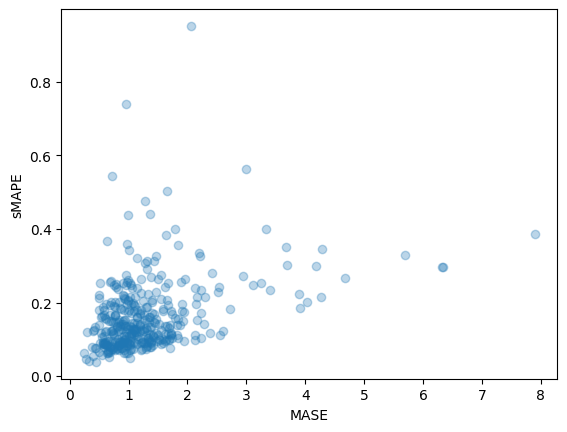

In [73]:
# Plot
plt.scatter(mase_metrics, smape_metrics, alpha = 0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [74]:
# Define a função para plotar a série temporal e previsões para um índice específico
def plot(ts_index):

    # Cria uma figura e um eixo para o plot
    fig, ax = plt.subplots(figsize = (10, 5))

    # Gera o índice de datas para a série temporal a partir dos metadados e do comprimento do alvo
    index = pd.period_range(start = dsa_dataset_teste[ts_index][FieldName.START],
                            periods = len(dsa_dataset_teste[ts_index][FieldName.TARGET]),
                            freq = freq).to_timestamp()

    # Configura os locais principais do eixo x para serem nos meses de janeiro e julho
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))

    # Configura os locais secundários do eixo x para serem em todos os meses
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    # Plota os valores reais da série temporal para os últimos 2 períodos de previsão
    ax.plot(index[-2*prediction_length:],
            dsa_dataset_teste[ts_index]["target"][-2*prediction_length:],
            label="Valor Real")

    # Plota a mediana das previsões para o último período de previsão
    plt.plot(index[-prediction_length:],
             np.median(forecasts[ts_index], axis=0),
             label = "Mediana das Previsões")

    # Preenche a área entre a média menos o desvio padrão e a média mais o desvio padrão das previsões
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha = 0.3,
        interpolate = True,
        label = "+/- 1-std",
    )

    # Adiciona uma legenda ao plot
    plt.legend()

    # Exibe o plot
    plt.show()

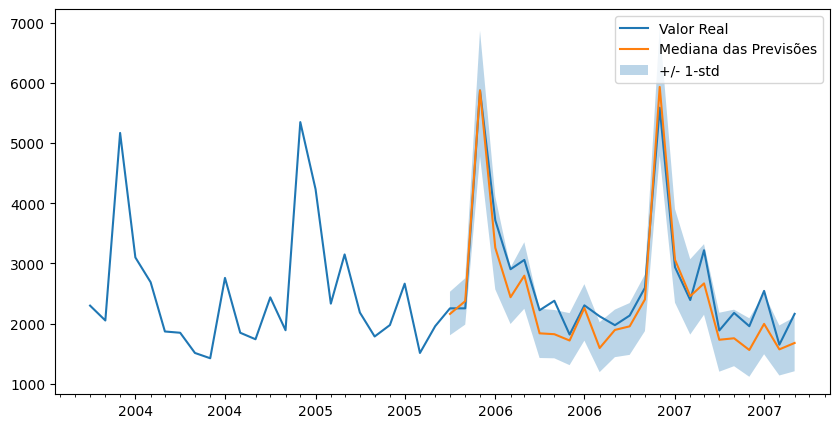

In [75]:
# Previsão para o índice 334
plot(334)

In [76]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [77]:
#%watermark -v -m

In [78]:
#%watermark --iversions

# Fim